# <center> Newman on custom trace and user graph </center>

In [1]:
import util
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [2]:
trace_path = "../Datasets/trace_test.txt"

Get authors.

In [3]:
Author = util.get_authors(trace_path)

Get users.

In [4]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [5]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

0 0 9 -1
1 0.19761178684143316 14 -1
2 0.22897749303630008 9 -1
3 0.27817540573473964 3 2
4 0.5629811737376177 24 -1
5 0.5680854304938732 40 -1


Useful function to flatten a list of lists or values from dict of dicts.

In [6]:
def flatten(obj):
    if type(obj) == list:
        return [l for L in obj for l in L]
    if type(obj) == dict:
        return [l for i in obj for l in obj[i].values()]

# example
liste = [[3,5], [0,-7,12], [45]]
print("Example on {} : {}".format(liste, flatten(liste)))
dico = {1: {4:56, 2:45}, 3: {6:32}}
print("Example on {} : {}".format(dico, flatten(dico)))

Example on [[3, 5], [0, -7, 12], [45]] : [3, 5, 0, -7, 12, 45]
Example on {1: {4: 56, 2: 45}, 3: {6: 32}} : [56, 45, 32]


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [7]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E with maximum value at 30.

In [8]:
# init
E = dict()

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet of known author
    if rtid != -1 and rtid in Author:
        rtu = Author[rtid]
        if rtu != uid: # no self-edges
            if uid in E:
                if rtu in E[uid] and E[uid][rtu]<30: # max E=30
                    E[uid][rtu] += 1
                else:
                    E[uid][rtu] = 1
            else:
                E[uid] = {rtu: 1}

## 2. Iterations

Function to compute Qij.

In [9]:
def computeQij(w,a,b,nij,eij):
    return (w * a**eij * (1-a)**(nij-eij)) / (w * a**eij * (1-a)**(nij-eij) + (1-w) * b**eij * (1-b)**(nij-eij))

Choose parameters.

In [11]:
eps = 10**(-3)
zeroN_prec = 10**(-2)
repetitions = 1
max_iter = 100
verbose = True

Proceed NEW VERSION SPARSE.

In [19]:
# at each repetition we save the values of w, a and b
results = {'N':list(), 'w':list(), 'a':list(), 'b':list()}

# Q dict
Q = {i: {j:0 for j in E[i]} for i in E}

for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # initialization of the parameters
        N = max(flatten(E)) # the smallest possible value
        w = random.uniform(0, 0.2)
        a = random.uniform(0.5, 1)
        b = random.uniform(0, 0.5)
        if verbose:
            print("N, w, a, b = ", N, w, a, b)
            print()

        # iter
        for l in range(max_iter):

            old_N, old_w, old_a, old_b = N, w, a, b
                    
            # compute Qij and phi
            for i in E:
                for j in E[i]:
                    Q[i][j] = computeQij(w, a, b, N, E[i][j])
            phi = w*n*(n-1) - sum(flatten(Q))
            if verbose:
                print("sum Q = ", sum(flatten(Q)))
                print("phi = ", phi)
                print()
            
            # up N and Q while phi<0
            loop = False # to track if we enter the loop or not
            while phi<0:
                loop = True
                N += 1
                for i in E:
                    for j in E[i]:
                        Q[i][j] = computeQij(w, a, b, N, E[i][j])
                old_phi = phi
                phi = w*n*(n-1) - sum(flatten(Q))
                if verbose:
                    print("N, phi = ", N, phi)
                
            # if we looped then dichotomy to get the best value for N (with precision zeroN_prec)
            if loop:
                N1, N2 = N-1, N
                if verbose:
                    print("\nN1, N2 = ", N1, N2)
                    print()
                while np.abs(phi) > zeroN_prec:
                    N_middle = (N1 + N2) / 2
                    if verbose:
                        print("N_middle = ", N_middle)
                    for i in E:
                        for j in E[i]:
                            Q[i][j] = computeQij(w, a, b, N_middle, E[i][j])
                    phi = w*n*(n-1) - sum(flatten(Q))
                    if phi < 0:
                        N1, N2 = N_middle, N2
                    else:
                        N1, N2 = N1, N_middle
                    if verbose:
                        print("phi = ", phi)
                        print()
                # finally update N
                N = N_middle
            
            # update w, a, b
            sumQ = sum(flatten(Q))
            w = sumQ / (n*(n-1))
            a, b = 0, 0
            for i in E:
                for j in E[i]:
                    eij = E[i][j]
                    qij = Q[i][j]
                    a += qij * eij
                    b += (1-qij) * eij
            a /= N * sumQ
            b /= N * (n*(n-1) - sumQ)
            if verbose:
                print("N, w, a, b = ", N, w, a, b)
                print()
            
            # break if no sufficient evolution after at least one iteration
            # INCOMPLETE
            new_q = np.array(flatten(Q))
            if l>0 and np.linalg.norm(new_q - old_q, np.inf) < eps:
                if verbose:
                    print("stop because eps")
                break
            
            # register old_q
            old_q = new_q
            
        # add results to results dict
        results['N'].append(N)
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        print(e)
        continue

N, w, a, b =  25 0.06399729431353854 0.8831087851594674 0.4882174687096962

sum Q =  10.979586489287758
phi =  145.81378457888167

N, w, a, b =  25 0.004481463873178677 0.8696621608308667 0.07303402140546063

sum Q =  65.47088221880817
phi =  -54.49129572952042

N, phi =  26 -48.26667131749666
N, phi =  27 -40.33117902524312
N, phi =  28 -34.691004160228786
N, phi =  29 -29.674420103738438
N, phi =  30 -25.231291014568097
N, phi =  31 -21.070399365477623
N, phi =  32 -16.560178866429958
N, phi =  33 -14.387850186111205
N, phi =  34 -12.58397296221516
N, phi =  35 -10.762503754268767
N, phi =  36 -7.4956734630298065
N, phi =  37 -5.022692649020023
N, phi =  38 -3.023965557887788
N, phi =  39 -1.3391520323659485
N, phi =  40 -0.3096846263859554
N, phi =  41 0.7036479996511353

N1, N2 =  40 41

N_middle =  40.5
phi =  0.242109945253004

N_middle =  40.25
phi =  -0.030407645947393647

N_middle =  40.375
phi =  0.10800265819804444

N_middle =  40.3125
phi =  0.03917654286702721

N_middle = 

N, phi =  211.78125 -36.17699760984595
N, phi =  212.78125 -35.49558953444954
N, phi =  213.78125 -34.82684777362821
N, phi =  214.78125 -34.16935875348474
N, phi =  215.78125 -33.521856868909886
N, phi =  216.78125 -32.88332300712379
N, phi =  217.78125 -32.25304501712301
N, phi =  218.78125 -31.630635395806664
N, phi =  219.78125 -31.01600638064292
N, phi =  220.78125 -30.40930761395468
N, phi =  221.78125 -29.810835970782897
N, phi =  222.78125 -29.220930398218755
N, phi =  223.78125 -28.639866198372914
N, phi =  224.78125 -28.067762855270068
N, phi =  225.78125 -27.50451734272024
N, phi =  226.78125 -26.949771250564694
N, phi =  227.78125 -26.40291563070904
N, phi =  228.78125 -25.86313284734276
N, phi =  229.78125 -25.329470489645757
N, phi =  230.78125 -24.80093897563504
N, phi =  231.78125 -24.276622069803082
N, phi =  232.78125 -23.75578824798105
N, phi =  233.78125 -23.237990693173074
N, phi =  234.78125 -22.723144694534696
N, phi =  235.78125 -22.211573325928278
N, phi =  236

N, phi =  445.53125 -34.423309383110336
N, phi =  446.53125 -34.10944872497734
N, phi =  447.53125 -33.79789137960586
N, phi =  448.53125 -33.48853586164475
N, phi =  449.53125 -33.181292948052274
N, phi =  450.53125 -32.87608666161775
N, phi =  451.53125 -32.57285482023056
N, phi =  452.53125 -32.27154914929362
N, phi =  453.53125 -31.972134966451687
N, phi =  454.53125 -31.674590459356626
N, phi =  455.53125 -31.37890558826579
N, phi =  456.53125 -31.085080655432353
N, phi =  457.53125 -30.793124592271464
N, phi =  458.53125 -30.503053022851258
N, phi =  459.53125 -30.214886168005986
N, phi =  460.53125 -29.928646658286414
N, phi =  461.53125 -29.644357325709148
N, phi =  462.53125 -29.36203904398062
N, phi =  463.53125 -29.081708684385948
N, phi =  464.53125 -28.803377250203486
N, phi =  465.53125 -28.527048246216605
N, phi =  466.53125 -28.252716332193256
N, phi =  467.53125 -27.980366300171386
N, phi =  468.53125 -27.709972405444287
N, phi =  469.53125 -27.441498070645363
N, phi =

N, phi =  658.78125 -91.99890423214129
N, phi =  659.78125 -91.75314652264758
N, phi =  660.78125 -91.50779098548199
N, phi =  661.78125 -91.26282375867433
N, phi =  662.78125 -91.01823002577883
N, phi =  663.78125 -90.77399406842504
N, phi =  664.78125 -90.53009932553192
N, phi =  665.78125 -90.28652845882449
N, phi =  666.78125 -90.04326342432897
N, phi =  667.78125 -89.8002855493375
N, phi =  668.78125 -89.55757561443474
N, phi =  669.78125 -89.31511394011358
N, phi =  670.78125 -89.0728804774339
N, phi =  671.78125 -88.83085490221262
N, phi =  672.78125 -88.58901671219706
N, phi =  673.78125 -88.34734532665087
N, phi =  674.78125 -88.10582018775399
N, phi =  675.78125 -87.86442086323277
N, phi =  676.78125 -87.62312714966359
N, phi =  677.78125 -87.38191917573381
N, phi =  678.78125 -87.14077750499905
N, phi =  679.78125 -86.8996832374026
N, phi =  680.78125 -86.65861810901853
N, phi =  681.78125 -86.41756458945636
N, phi =  682.78125 -86.17650597625034
N, phi =  683.78125 -85.9354

N, phi =  930.78125 -34.52188798125876
N, phi =  931.78125 -34.37131682746745
N, phi =  932.78125 -34.221292848541445
N, phi =  933.78125 -34.07180460414256
N, phi =  934.78125 -33.92284113299498
N, phi =  935.78125 -33.77439199002692
N, phi =  936.78125 -33.62644727920401
N, phi =  937.78125 -33.47899768191142
N, phi =  938.78125 -33.33203448078017
N, phi =  939.78125 -33.18554957888144
N, phi =  940.78125 -33.03953551422018
N, phi =  941.78125 -32.89398546953024
N, phi =  942.78125 -32.74889327735969
N, phi =  943.78125 -32.60425342047845
N, phi =  944.78125 -32.46006102770019
N, phi =  945.78125 -32.316311865160756
N, phi =  946.78125 -32.17300232323246
N, phi =  947.78125 -32.030129399170725
N, phi =  948.78125 -31.887690675704157
N, phi =  949.78125 -31.745684295736467
N, phi =  950.78125 -31.604108933412952
N, phi =  951.78125 -31.462963761764584
N, phi =  952.78125 -31.322248417229304
N, phi =  953.78125 -31.181962961303817
N, phi =  954.78125 -31.04210783965364
N, phi =  955.78

N, phi =  1193.78125 -9.013530164230199
N, phi =  1194.78125 -8.941784857002832
N, phi =  1195.78125 -8.869949411765491
N, phi =  1196.78125 -8.798038169232301
N, phi =  1197.78125 -8.726065728937256
N, phi =  1198.78125 -8.654046905598426
N, phi =  1199.78125 -8.581996684733129
N, phi =  1200.78125 -8.509930177739578
N, phi =  1201.78125 -8.437862576662292
N, phi =  1202.78125 -8.365809108864648
N, phi =  1203.78125 -8.293784991829758
N, phi =  1204.78125 -8.221805388315518
N, phi =  1205.78125 -8.149885362080399
N, phi =  1206.78125 -8.078039834403226
N, phi =  1207.78125 -8.006283541604821
N, phi =  1208.78125 -7.934630993782365
N, phi =  1209.78125 -7.863096434952274
N, phi =  1210.78125 -7.791693804794297
N, phi =  1211.78125 -7.720436702174803
N, phi =  1212.78125 -7.64933835061907
N, phi =  1213.78125 -7.5784115658876505
N, phi =  1214.78125 -7.5076687257996735
N, phi =  1215.78125 -7.43712174243276
N, phi =  1216.78125 -7.366782036810909
N, phi =  1217.78125 -7.296660516180674


N, phi =  1458.28125 -83.02339031827175
N, phi =  1459.28125 -82.90800885149213
N, phi =  1460.28125 -82.7926056266142
N, phi =  1461.28125 -82.67718106026331
N, phi =  1462.28125 -82.56173564575838
N, phi =  1463.28125 -82.44626995268118
N, phi =  1464.28125 -82.33078462633635
N, phi =  1465.28125 -82.21528038715543
N, phi =  1466.28125 -82.09975802995548
N, phi =  1467.28125 -81.9842184231672
N, phi =  1468.28125 -81.8686625079144
N, phi =  1469.28125 -81.75309129704408
N, phi =  1470.28125 -81.63750587404438
N, phi =  1471.28125 -81.52190739189493
N, phi =  1472.28125 -81.40629707180148
N, phi =  1473.28125 -81.29067620187915
N, phi =  1474.28125 -81.17504613573357
N, phi =  1475.28125 -81.05940829095891
N, phi =  1476.28125 -80.94376414756144
N, phi =  1477.28125 -80.82811524631329
N, phi =  1478.28125 -80.71246318700894
N, phi =  1479.28125 -80.59680962667386
N, phi =  1480.28125 -80.48115627768311
N, phi =  1481.28125 -80.36550490581794
N, phi =  1482.28125 -80.24985732825539
N, 

N, phi =  1785.28125 -48.579394049720015
N, phi =  1786.28125 -48.4861657569969
N, phi =  1787.28125 -48.392979680765585
N, phi =  1788.28125 -48.29983562431256
N, phi =  1789.28125 -48.20673344922154
N, phi =  1790.28125 -48.11367307613227
N, phi =  1791.28125 -48.0206544853875
N, phi =  1792.28125 -47.92767771763277
N, phi =  1793.28125 -47.83474287433703
N, phi =  1794.28125 -47.74185011821763
N, phi =  1795.28125 -47.64899967362597
N, phi =  1796.28125 -47.55619182681459
N, phi =  1797.28125 -47.463426926156174
N, phi =  1798.28125 -47.370705382280484
N, phi =  1799.28125 -47.278027668116906
N, phi =  1800.28125 -47.18539431888028
N, phi =  1801.28125 -47.0928059319651
N, phi =  1802.28125 -47.000263166759325
N, phi =  1803.28125 -46.907766744398856
N, phi =  1804.28125 -46.815317447417556
N, phi =  1805.28125 -46.72291611933832
N, phi =  1806.28125 -46.630563664187164
N, phi =  1807.28125 -46.53826104591752
N, phi =  1808.28125 -46.446009287770586
N, phi =  1809.28125 -46.35380947

N, phi =  2019.28125 -29.90896588960539
N, phi =  2020.28125 -29.844219213346832
N, phi =  2021.28125 -29.77957357085807
N, phi =  2022.28125 -29.71502911076326
N, phi =  2023.28125 -29.65058597441933
N, phi =  2024.28125 -29.586244294873104
N, phi =  2025.28125 -29.522004195836267
N, phi =  2026.28125 -29.457865790688082
N, phi =  2027.28125 -29.393829181497594
N, phi =  2028.28125 -29.32989445807077
N, phi =  2029.28125 -29.266061697028228
N, phi =  2030.28125 -29.202330960907673
N, phi =  2031.28125 -29.138702297294806
N, phi =  2032.28125 -29.075175737990747
N, phi =  2033.28125 -29.011751298205134
N, phi =  2034.28125 -28.948428975786676
N, phi =  2035.28125 -28.885208750490342
N, phi =  2036.28125 -28.82209058327374
N, phi =  2037.28125 -28.759074415637734
N, phi =  2038.28125 -28.69616016899947
N, phi =  2039.28125 -28.633347744109066
N, phi =  2040.28125 -28.57063702050351
N, phi =  2041.28125 -28.508027856000645
N, phi =  2042.28125 -28.44552008623767
N, phi =  2043.28125 -28.

N, phi =  2349.28125 -13.787548351519595
N, phi =  2350.28125 -13.75746084492319
N, phi =  2351.28125 -13.7274196639027
N, phi =  2352.28125 -13.697423491885553
N, phi =  2353.28125 -13.667471015223375
N, phi =  2354.28125 -13.637560923041827
N, phi =  2355.28125 -13.607691907089771
N, phi =  2356.28125 -13.577862661589757
N, phi =  2357.28125 -13.548071883092154
N, phi =  2358.28125 -13.518318270328821
N, phi =  2359.28125 -13.488600524074103
N, phi =  2360.28125 -13.458917347005494
N, phi =  2361.28125 -13.429267443571886
N, phi =  2362.28125 -13.399649519866907
N, phi =  2363.28125 -13.37006228350601
N, phi =  2364.28125 -13.34050444351242
N, phi =  2365.28125 -13.310974710209484
N, phi =  2366.28125 -13.2814717951192
N, phi =  2367.28125 -13.251994410871783
N, phi =  2368.28125 -13.222541271121605
N, phi =  2369.28125 -13.193111090474313
N, phi =  2370.28125 -13.163702584422273
N, phi =  2371.28125 -13.134314469291523
N, phi =  2372.28125 -13.104945462199987
N, phi =  2373.28125 -1

N, phi =  2647.28125 -4.482761589542143
N, phi =  2648.28125 -4.455650723178911
N, phi =  2649.28125 -4.428601081339437
N, phi =  2650.28125 -4.401612602014032
N, phi =  2651.28125 -4.374685235062319
N, phi =  2652.28125 -4.347818942327317
N, phi =  2653.28125 -4.321013697726903
N, phi =  2654.28125 -4.294269487322911
N, phi =  2655.28125 -4.267586309367747
N, phi =  2656.28125 -4.240964174329122
N, phi =  2657.28125 -4.214403104892325
N, phi =  2658.28125 -4.18790313594061
N, phi =  2659.28125 -4.1614643145141255
N, phi =  2660.28125 -4.13508669974761
N, phi =  2661.28125 -4.108770362785778
N, phi =  2662.28125 -4.08251538667918
N, phi =  2663.28125 -4.056321866258491
N, phi =  2664.28125 -4.030189907988982
N, phi =  2665.28125 -4.004119629804878
N, phi =  2666.28125 -3.9781111609241027
N, phi =  2667.28125 -3.9521646416446092
N, phi =  2668.28125 -3.926280223121088
N, phi =  2669.28125 -3.900458067124042
N, phi =  2670.28125 -3.874698345781473
N, phi =  2671.28125 -3.849001241302572


N, phi =  1442.28125 -84.86831635435617
N, phi =  1443.28125 -84.75327805958239
N, phi =  1444.28125 -84.6382217665497
N, phi =  1445.28125 -84.52314668216096
N, phi =  1446.28125 -84.40805208432069
N, phi =  1447.28125 -84.29293732297003
N, phi =  1448.28125 -84.17780182101617
N, phi =  1449.28125 -84.06264507518772
N, phi =  1450.28125 -83.94746665679992
N, phi =  1451.28125 -83.83226621244638
N, phi =  1452.28125 -83.71704346456582
N, phi =  1453.28125 -83.60179821195679
N, phi =  1454.28125 -83.48653033019315
N, phi =  1455.28125 -83.37123977190996
N, phi =  1456.28125 -83.25592656706726
N, phi =  1457.28125 -83.14059082305126
N, phi =  1458.28125 -83.02523272471907
N, phi =  1459.28125 -82.90985253435555
N, phi =  1460.28125 -82.79445059150082
N, phi =  1461.28125 -82.67902731272663
N, phi =  1462.28125 -82.56358319128096
N, phi =  1463.28125 -82.44811879665988
N, phi =  1464.28125 -82.33263477409636
N, phi =  1465.28125 -82.21713184390917
N, phi =  1466.28125 -82.10161080082577
N

N, phi =  1675.28125 -59.28987256707492
N, phi =  1676.28125 -59.18745588268173
N, phi =  1677.28125 -59.085116110668324
N, phi =  1678.28125 -58.982854655730435
N, phi =  1679.28125 -58.880672910153564
N, phi =  1680.28125 -58.77857225176743
N, phi =  1681.28125 -58.67655404193495
N, phi =  1682.28125 -58.574619623571024
N, phi =  1683.28125 -58.47277031918675
N, phi =  1684.28125 -58.37100742896651
N, phi =  1685.28125 -58.26933222889332
N, phi =  1686.28125 -58.167745968894465
N, phi =  1687.28125 -58.06624987104638
N, phi =  1688.28125 -57.96484512781343
N, phi =  1689.28125 -57.86353290034005
N, phi =  1690.28125 -57.76231431678687
N, phi =  1691.28125 -57.661190470723454
N, phi =  1692.28125 -57.5601624195715
N, phi =  1693.28125 -57.459231183109466
N, phi =  1694.28125 -57.35839774202067
N, phi =  1695.28125 -57.2576630365281
N, phi =  1696.28125 -57.157027965066916
N, phi =  1697.28125 -57.05649338303169
N, phi =  1698.28125 -56.95606010158667
N, phi =  1699.28125 -56.855728886

N, phi =  1990.28125 -31.83214000377071
N, phi =  1991.28125 -31.764520815700493
N, phi =  1992.28125 -31.69700018590285
N, phi =  1993.28125 -31.629577993072395
N, phi =  1994.28125 -31.562254139592298
N, phi =  1995.28125 -31.495028550698237
N, phi =  1996.28125 -31.427901173606543
N, phi =  1997.28125 -31.360871976609005
N, phi =  1998.28125 -31.293940948141838
N, phi =  1999.28125 -31.227108095826715
N, phi =  2000.28125 -31.160373445489107
N, phi =  2001.28125 -31.093737040144752
N, phi =  2002.28125 -31.0271989389734
N, phi =  2003.28125 -30.960759216267903
N, phi =  2004.28125 -30.89441796036496
N, phi =  2005.28125 -30.82817527255949
N, phi =  2006.28125 -30.762031266004037
N, phi =  2007.28125 -30.695986064598443
N, phi =  2008.28125 -30.630039801861244
N, phi =  2009.28125 -30.564192619803165
N, phi =  2010.28125 -30.49844466778201
N, phi =  2011.28125 -30.432796101357752
N, phi =  2012.28125 -30.3672470811452
N, phi =  2013.28125 -30.30179777166689
N, phi =  2014.28125 -30.2

N, phi =  2332.28125 -14.309542458869318
N, phi =  2333.28125 -14.278461931893952
N, phi =  2334.28125 -14.247450706872675
N, phi =  2335.28125 -14.216507397202387
N, phi =  2336.28125 -14.185630621195157
N, phi =  2337.28125 -14.15481900202026
N, phi =  2338.28125 -14.124071167638357
N, phi =  2339.28125 -14.093385750723316
N, phi =  2340.28125 -14.062761388576225
N, phi =  2341.28125 -14.032196723028695
N, phi =  2342.28125 -14.001690400339497
N, phi =  2343.28125 -13.971241071082583
N, phi =  2344.28125 -13.940847390027654
N, phi =  2345.28125 -13.91050801601711
N, phi =  2346.28125 -13.88022161183284
N, phi =  2347.28125 -13.849986844062348
N, phi =  2348.28125 -13.819802382958
N, phi =  2349.28125 -13.78966690229411
N, phi =  2350.28125 -13.759579079220407
N, phi =  2351.28125 -13.729537594112996
N, phi =  2352.28125 -13.699541130425287
N, phi =  2353.28125 -13.669588374535868
N, phi =  2354.28125 -13.639678015599545
N, phi =  2355.28125 -13.609808745394433
N, phi =  2356.28125 -1

N, phi =  2674.28125 -3.774452015397369
N, phi =  2675.28125 -3.7490068318965513
N, phi =  2676.28125 -3.7236253124075454
N, phi =  2677.28125 -3.698307692809042
N, phi =  2678.28125 -3.673054216700285
N, phi =  2679.28125 -3.647865135008592
N, phi =  2680.28125 -3.62274070558556
N, phi =  2681.28125 -3.5976811927918266
N, phi =  2682.28125 -3.572686867071795
N, phi =  2683.28125 -3.5477580045180765
N, phi =  2684.28125 -3.5228948864278795
N, phi =  2685.28125 -3.4980977988504076
N, phi =  2686.28125 -3.473367032127193
N, phi =  2687.28125 -3.448702880425449
N, phi =  2688.28125 -3.4241056412657382
N, phi =  2689.28125 -3.399575615043638
N, phi =  2690.28125 -3.375113104547699
N, phi =  2691.28125 -3.350718414473251
N, phi =  2692.28125 -3.326391850932982
N, phi =  2693.28125 -3.302133720965722
N, phi =  2694.28125 -3.277944332042983
N, phi =  2695.28125 -3.253823991575203
N, phi =  2696.28125 -3.2297730064180072
N, phi =  2697.28125 -3.2057916823787256
N, phi =  2698.28125 -3.18188032

N, phi =  3000.78125 -86.34203677882522
N, phi =  3001.78125 -86.28732662913609
N, phi =  3002.78125 -86.23261637982618
N, phi =  3003.78125 -86.17790586000415
N, phi =  3004.78125 -86.1231949012616
N, phi =  3005.78125 -86.06848333774283
N, phi =  3006.78125 -86.01377100616563
N, phi =  3007.78125 -85.95905774589092
N, phi =  3008.78125 -85.90434339895259
N, phi =  3009.78125 -85.84962781010842
N, phi =  3010.78125 -85.79491082689259
N, phi =  3011.78125 -85.7401922996426
N, phi =  3012.78125 -85.68547208155137
N, phi =  3013.78125 -85.63075002871435
N, phi =  3014.78125 -85.5760260001621
N, phi =  3015.78125 -85.52129985790828
N, phi =  3016.78125 -85.4665714669833
N, phi =  3017.78125 -85.41184069548281
N, phi =  3018.78125 -85.3571074145932
N, phi =  3019.78125 -85.30237149864172
N, phi =  3020.78125 -85.2476328251286
N, phi =  3021.78125 -85.19289127476146
N, phi =  3022.78125 -85.13814673149456
N, phi =  3023.78125 -85.08339908256356
N, phi =  3024.78125 -85.02864821851638
N, phi

N, phi =  3333.78125 -68.42416521471634
N, phi =  3334.78125 -68.37336174451825
N, phi =  3335.78125 -68.3225756554149
N, phi =  3336.78125 -68.27180677703703
N, phi =  3337.78125 -68.2210549390348
N, phi =  3338.78125 -68.17031997113088
N, phi =  3339.78125 -68.1196017031759
N, phi =  3340.78125 -68.06889996519985
N, phi =  3341.78125 -68.01821458747578
N, phi =  3342.78125 -67.9675454005718
N, phi =  3343.78125 -67.91689223540132
N, phi =  3344.78125 -67.86625492328277
N, phi =  3345.78125 -67.81563329599469
N, phi =  3346.78125 -67.76502718582329
N, phi =  3347.78125 -67.71443642562707
N, phi =  3348.78125 -67.66386084887966
N, phi =  3349.78125 -67.61330028973089
N, phi =  3350.78125 -67.56275458306051
N, phi =  3351.78125 -67.5122235645191
N, phi =  3352.78125 -67.46170707059657
N, phi =  3353.78125 -67.41120493866578
N, phi =  3354.78125 -67.36071700703175
N, phi =  3355.78125 -67.3102431149929
N, phi =  3356.78125 -67.25978310287869
N, phi =  3357.78125 -67.2093368121143
N, phi 

N, phi =  3642.78125 -53.339985106482736
N, phi =  3643.78125 -53.2940381366658
N, phi =  3644.78125 -53.248112543123206
N, phi =  3645.78125 -53.20220821530797
N, phi =  3646.78125 -53.15632504108658
N, phi =  3647.78125 -53.110462906790026
N, phi =  3648.78125 -53.06462169724772
N, phi =  3649.78125 -53.01880129583823
N, phi =  3650.78125 -52.97300158450941
N, phi =  3651.78125 -52.92722244384987
N, phi =  3652.78125 -52.88146375310518
N, phi =  3653.78125 -52.835725390237506
N, phi =  3654.78125 -52.79000723195919
N, phi =  3655.78125 -52.74430915377864
N, phi =  3656.78125 -52.69863103005439
N, phi =  3657.78125 -52.65297273401942
N, phi =  3658.78125 -52.60733413784753
N, phi =  3659.78125 -52.56171511268474
N, phi =  3660.78125 -52.51611552870108
N, phi =  3661.78125 -52.47053525513144
N, phi =  3662.78125 -52.42497416033331
N, phi =  3663.78125 -52.379432111818296
N, phi =  3664.78125 -52.333908976307846
N, phi =  3665.78125 -52.288404619785496
N, phi =  3666.78125 -52.242918907

N, phi =  3999.78125 -38.04712226202274
N, phi =  4000.78125 -38.009437543154725
N, phi =  4001.78125 -37.97179386325614
N, phi =  4002.78125 -37.9341911589502
N, phi =  4003.78125 -37.896629364431725
N, phi =  4004.78125 -37.859108411498354
N, phi =  4005.78125 -37.821628229577186
N, phi =  4006.78125 -37.7841887457553
N, phi =  4007.78125 -37.74678988480382
N, phi =  4008.78125 -37.709431569216335
N, phi =  4009.78125 -37.67211371923209
N, phi =  4010.78125 -37.63483625286889
N, phi =  4011.78125 -37.59759908595756
N, phi =  4012.78125 -37.56040213216855
N, phi =  4013.78125 -37.52324530304541
N, phi =  4014.78125 -37.48612850804076
N, phi =  4015.78125 -37.44905165454321
N, phi =  4016.78125 -37.41201464791463
N, phi =  4017.78125 -37.37501739152485
N, phi =  4018.78125 -37.338059786780924
N, phi =  4019.78125 -37.3011417331677
N, phi =  4020.78125 -37.26426312827423
N, phi =  4021.78125 -37.22742386783913
N, phi =  4022.78125 -37.19062384577595
N, phi =  4023.78125 -37.153862954214

N, phi =  4332.78125 -27.152133857858892
N, phi =  4333.78125 -27.12339300629636
N, phi =  4334.78125 -27.094672796835802
N, phi =  4335.78125 -27.065973154037877
N, phi =  4336.78125 -27.037294001478337
N, phi =  4337.78125 -27.0086352617608
N, phi =  4338.78125 -26.97999685653447
N, phi =  4339.78125 -26.95137870650987
N, phi =  4340.78125 -26.922780731473424
N, phi =  4341.78125 -26.894202850308098
N, phi =  4342.78125 -26.865644981007918
N, phi =  4343.78125 -26.837107040697028
N, phi =  4344.78125 -26.808588945648992
N, phi =  4345.78125 -26.780090611303535
N, phi =  4346.78125 -26.75161195228697
N, phi =  4347.78125 -26.723152882431698
N, phi =  4348.78125 -26.694713314795692
N, phi =  4349.78125 -26.666293161683846
N, phi =  4350.78125 -26.637892334667313
N, phi =  4351.78125 -26.609510744605082
N, phi =  4352.78125 -26.581148301666687
N, phi =  4353.78125 -26.55280491535204
N, phi =  4354.78125 -26.524480494514826
N, phi =  4355.78125 -26.496174947385967
N, phi =  4356.78125 -2

N, phi =  4665.78125 -18.48628804782875
N, phi =  4666.78125 -18.464175271884955
N, phi =  4667.78125 -18.442100620130674
N, phi =  4668.78125 -18.420064173021608
N, phi =  4669.78125 -18.398066008825793
N, phi =  4670.78125 -18.376106203615038
N, phi =  4671.78125 -18.35418483125617
N, phi =  4672.78125 -18.332301963404568
N, phi =  4673.78125 -18.310457669495705
N, phi =  4674.78125 -18.288652016738133
N, phi =  4675.78125 -18.26688507010779
N, phi =  4676.78125 -18.245156892341917
N, phi =  4677.78125 -18.22346754393333
N, phi =  4678.78125 -18.201817083125313
N, phi =  4679.78125 -18.180205565907087
N, phi =  4680.78125 -18.158633046010884
N, phi =  4681.78125 -18.13709957490581
N, phi =  4682.78125 -18.11560520179684
N, phi =  4683.78125 -18.094149973621548
N, phi =  4684.78125 -18.07273393504704
N, phi =  4685.78125 -18.051357128469185
N, phi =  4686.78125 -18.03001959401019
N, phi =  4687.78125 -18.00872136951839
N, phi =  4688.78125 -17.987462490567424
N, phi =  4689.78125 -17.

N, phi =  4998.78125 -12.871795598688697
N, phi =  4999.78125 -12.857850633974211
N, phi =  5000.78125 -12.84390721936706
N, phi =  5001.78125 -12.829965218147917
N, phi =  5002.78125 -12.816024493668168
N, phi =  5003.78125 -12.80208490935159
N, phi =  5004.78125 -12.788146328698906
N, phi =  5005.78125 -12.774208615290116
N, phi =  5006.78125 -12.76027163278828
N, phi =  5007.78125 -12.74633524494338
N, phi =  5008.78125 -12.732399315595556
N, phi =  5009.78125 -12.718463708679701
N, phi =  5010.78125 -12.704528288229868
N, phi =  5011.78125 -12.690592918382857
N, phi =  5012.78125 -12.676657463382783
N, phi =  5013.78125 -12.66272178758693
N, phi =  5014.78125 -12.64878575546946
N, phi =  5015.78125 -12.634849231626982
N, phi =  5016.78125 -12.620912080783588
N, phi =  5017.78125 -12.60697416779704
N, phi =  5018.78125 -12.59303535766344
N, phi =  5019.78125 -12.579095515523575
N, phi =  5020.78125 -12.56515450666888
N, phi =  5021.78125 -12.55121219654763
N, phi =  5022.78125 -12.5

N, phi =  5331.78125 -7.814017448317115
N, phi =  5332.78125 -7.7978992280365045
N, phi =  5333.78125 -7.781788439302469
N, phi =  5334.78125 -7.765685231827158
N, phi =  5335.78125 -7.749589754355705
N, phi =  5336.78125 -7.733502154647818
N, phi =  5337.78125 -7.717422579459493
N, phi =  5338.78125 -7.701351174525373
N, phi =  5339.78125 -7.685288084540963
N, phi =  5340.78125 -7.669233453145724
N, phi =  5341.78125 -7.653187422905679
N, phi =  5342.78125 -7.637150135297075
N, phi =  5343.78125 -7.62112173068976
N, phi =  5344.78125 -7.605102348331256
N, phi =  5345.78125 -7.589092126331094
N, phi =  5346.78125 -7.573091201645132
N, phi =  5347.78125 -7.557099710060713
N, phi =  5348.78125 -7.541117786181614
N, phi =  5349.78125 -7.525145563413629
N, phi =  5350.78125 -7.509183173950698
N, phi =  5351.78125 -7.49323074876059
N, phi =  5352.78125 -7.4772884175717405
N, phi =  5353.78125 -7.4613563088600525
N, phi =  5354.78125 -7.445434549836095
N, phi =  5355.78125 -7.429523266432378

N, phi =  5664.78125 -3.2081713219954846
N, phi =  5665.78125 -3.19679323036819
N, phi =  5666.78125 -3.185431021794047
N, phi =  5667.78125 -3.174084727980233
N, phi =  5668.78125 -3.1627543804998552
N, phi =  5669.78125 -3.15144001078046
N, phi =  5670.78125 -3.1401416500923407
N, phi =  5671.78125 -3.1288593295372475
N, phi =  5672.78125 -3.1175930800369596
N, phi =  5673.78125 -3.1063429323217484
N, phi =  5674.78125 -3.0951089169193295
N, phi =  5675.78125 -3.083891064143522
N, phi =  5676.78125 -3.072689404082851
N, phi =  5677.78125 -3.0615039665898536
N, phi =  5678.78125 -3.0503347812698376
N, phi =  5679.78125 -3.039181877469856
N, phi =  5680.78125 -3.0280452842679573
N, phi =  5681.78125 -3.016925030462538
N, phi =  5682.78125 -3.005821144561194
N, phi =  5683.78125 -2.9947336547705508
N, phi =  5684.78125 -2.9836625889856947
N, phi =  5685.78125 -2.9726079747795477
N, phi =  5686.78125 -2.9615698393924834
N, phi =  5687.78125 -2.950548209722678
N, phi =  5688.78125 -2.9395

N, phi =  5997.78125 -0.26609274307291386
N, phi =  5998.78125 -0.25920883294582
N, phi =  5999.78125 -0.252332749754407
N, phi =  6000.78125 -0.2454644758742628
N, phi =  6001.78125 -0.23860399381502795
N, phi =  6002.78125 -0.23175128621513963
N, phi =  6003.78125 -0.22490633583655573
N, phi =  6004.78125 -0.2180691255591487
N, phi =  6005.78125 -0.2112396383755808
N, phi =  6006.78125 -0.20441785738578488
N, phi =  6007.78125 -0.19760376579143646
N, phi =  6008.78125 -0.19079734689078442
N, phi =  6009.78125 -0.1839985840730165
N, phi =  6010.78125 -0.17720746081305982
N, phi =  6011.78125 -0.17042396066592502
N, phi =  6012.78125 -0.1636480672614109
N, phi =  6013.78125 -0.1568797642987363
N, phi =  6014.78125 -0.15011903554110972
N, phi =  6015.78125 -0.14336586481023694
N, phi =  6016.78125 -0.1366202359810007
N, phi =  6017.78125 -0.12988213297612639
N, phi =  6018.78125 -0.12315153976082094
N, phi =  6019.78125 -0.11642844033728217
N, phi =  6020.78125 -0.10971281873963257
N, p

N, phi =  3163.78125 -77.3935090617451
N, phi =  3164.78125 -77.33887346577063
N, phi =  3165.78125 -77.28425190953607
N, phi =  3166.78125 -77.22964463473195
N, phi =  3167.78125 -77.1750518821037
N, phi =  3168.78125 -77.12047389138272
N, phi =  3169.78125 -77.06591090123462
N, phi =  3170.78125 -77.01136314918995
N, phi =  3171.78125 -76.9568308715969
N, phi =  3172.78125 -76.90231430354137
N, phi =  3173.78125 -76.84781367880802
N, phi =  3174.78125 -76.79332922981348
N, phi =  3175.78125 -76.73886118753754
N, phi =  3176.78125 -76.68440978148874
N, phi =  3177.78125 -76.62997523962508
N, phi =  3178.78125 -76.5755577883024
N, phi =  3179.78125 -76.52115765223036
N, phi =  3180.78125 -76.46677505440192
N, phi =  3181.78125 -76.41241021604046
N, phi =  3182.78125 -76.35806335655579
N, phi =  3183.78125 -76.3037346934716
N, phi =  3184.78125 -76.24942444239778
N, phi =  3185.78125 -76.195132816952
N, phi =  3186.78125 -76.14086002871824
N, phi =  3187.78125 -76.08660628720023
N, phi 

N, phi =  3496.78125 -60.29024144318489
N, phi =  3497.78125 -60.24117661764078
N, phi =  3498.78125 -60.192125990030824
N, phi =  3499.78125 -60.143089709068526
N, phi =  3500.78125 -60.094067923966
N, phi =  3501.78125 -60.04506078439592
N, phi =  3502.78125 -59.996068440436225
N, phi =  3503.78125 -59.94709104252032
N, phi =  3504.78125 -59.89812874138217
N, phi =  3505.78125 -59.849181688015555
N, phi =  3506.78125 -59.800250033613544
N, phi =  3507.78125 -59.75133392951755
N, phi =  3508.78125 -59.70243352717697
N, phi =  3509.78125 -59.6535489780855
N, phi =  3510.78125 -59.604680433737165
N, phi =  3511.78125 -59.55582804557522
N, phi =  3512.78125 -59.50699196494032
N, phi =  3513.78125 -59.458172343016734
N, phi =  3514.78125 -59.40936933078989
N, phi =  3515.78125 -59.36058307898565
N, phi =  3516.78125 -59.311813738030445
N, phi =  3517.78125 -59.26306145799132
N, phi =  3518.78125 -59.21432638853272
N, phi =  3519.78125 -59.165608678864395
N, phi =  3520.78125 -59.116908477

N, phi =  3829.78125 -45.00309573278849
N, phi =  3830.78125 -44.95970111723448
N, phi =  3831.78125 -44.916324091079474
N, phi =  3832.78125 -44.87296485650445
N, phi =  3833.78125 -44.82962361742898
N, phi =  3834.78125 -44.78630057946439
N, phi =  3835.78125 -44.74299594987658
N, phi =  3836.78125 -44.69970993752811
N, phi =  3837.78125 -44.65644275284922
N, phi =  3838.78125 -44.61319460777442
N, phi =  3839.78125 -44.5699657157089
N, phi =  3840.78125 -44.526756291472594
N, phi =  3841.78125 -44.48356655126052
N, phi =  3842.78125 -44.44039671258697
N, phi =  3843.78125 -44.39724699424686
N, phi =  3844.78125 -44.354117616256914
N, phi =  3845.78125 -44.31100879981767
N, phi =  3846.78125 -44.2679207672532
N, phi =  3847.78125 -44.224853741972275
N, phi =  3848.78125 -44.181807948407744
N, phi =  3849.78125 -44.13878361197799
N, phi =  3850.78125 -44.09578095902683
N, phi =  3851.78125 -44.05280021677941
N, phi =  3852.78125 -44.0098416132892
N, phi =  3853.78125 -43.9669053773869

N, phi =  4162.78125 -32.3633679923477
N, phi =  4163.78125 -32.330802163632846
N, phi =  4164.78125 -32.298259196150816
N, phi =  4165.78125 -32.26573905202953
N, phi =  4166.78125 -32.233241694870905
N, phi =  4167.78125 -32.2007670897403
N, phi =  4168.78125 -32.168315203153725
N, phi =  4169.78125 -32.13588600306501
N, phi =  4170.78125 -32.10347945885435
N, phi =  4171.78125 -32.07109554131125
N, phi =  4172.78125 -32.03873422262596
N, phi =  4173.78125 -32.00639547636767
N, phi =  4174.78125 -31.974079277473955
N, phi =  4175.78125 -31.941785602236017
N, phi =  4176.78125 -31.909514428279635
N, phi =  4177.78125 -31.877265734549788
N, phi =  4178.78125 -31.84503950129345
N, phi =  4179.78125 -31.812835710044915
N, phi =  4180.78125 -31.780654343604816
N, phi =  4181.78125 -31.7484953860234
N, phi =  4182.78125 -31.71635882257992
N, phi =  4183.78125 -31.684244639767527
N, phi =  4184.78125 -31.652152825271692
N, phi =  4185.78125 -31.620083367947863
N, phi =  4186.78125 -31.58803

N, phi =  4495.78125 -22.6794344876189
N, phi =  4496.78125 -22.65304010682442
N, phi =  4497.78125 -22.626658270779522
N, phi =  4498.78125 -22.600289058208816
N, phi =  4499.78125 -22.57393255002883
N, phi =  4500.78125 -22.547588829339595
N, phi =  4501.78125 -22.521257981416788
N, phi =  4502.78125 -22.494940093700983
N, phi =  4503.78125 -22.46863525578985
N, phi =  4504.78125 -22.442343559426504
N, phi =  4505.78125 -22.41606509848959
N, phi =  4506.78125 -22.389799968980782
N, phi =  4507.78125 -22.36354826901357
N, phi =  4508.78125 -22.337310098801588
N, phi =  4509.78125 -22.311085560643512
N, phi =  4510.78125 -22.28487475891213
N, phi =  4511.78125 -22.258677800038157
N, phi =  4512.78125 -22.232494792496787
N, phi =  4513.78125 -22.206325846791884
N, phi =  4514.78125 -22.180171075441237
N, phi =  4515.78125 -22.154030592959906
N, phi =  4516.78125 -22.12790451584273
N, phi =  4517.78125 -22.101792962549425
N, phi =  4518.78125 -22.075696053484265
N, phi =  4519.78125 -22.

N, phi =  4828.78125 -15.383254860862515
N, phi =  4829.78125 -15.366976731056806
N, phi =  4830.78125 -15.350725152545564
N, phi =  4831.78125 -15.334499966960031
N, phi =  4832.78125 -15.318301015793843
N, phi =  4833.78125 -15.302128140415704
N, phi =  4834.78125 -15.285981182082942
N, phi =  4835.78125 -15.269859981951889
N, phi =  4836.78125 -15.253764381092193
N, phi =  4837.78125 -15.237694220497264
N, phi =  4838.78125 -15.221649341095592
N, phi =  4839.78125 -15.205629583763805
N, phi =  4840.78125 -15.189634789336306
N, phi =  4841.78125 -15.173664798617185
N, phi =  4842.78125 -15.157719452390534
N, phi =  4843.78125 -15.141798591431712
N, phi =  4844.78125 -15.125902056516257
N, phi =  4845.78125 -15.110029688431876
N, phi =  4846.78125 -15.094181327986867
N, phi =  4847.78125 -15.07835681602075
N, phi =  4848.78125 -15.062555993413273
N, phi =  4849.78125 -15.04677870109358
N, phi =  4850.78125 -15.031024780049645
N, phi =  4851.78125 -15.015294071336669
N, phi =  4852.781

N, phi =  5161.78125 -10.5322301036767
N, phi =  5162.78125 -10.51700960445607
N, phi =  5163.78125 -10.501775682911692
N, phi =  5164.78125 -10.486528347404278
N, phi =  5165.78125 -10.47126760812051
N, phi =  5166.78125 -10.455993477076554
N, phi =  5167.78125 -10.440705968122991
N, phi =  5168.78125 -10.425405096947255
N, phi =  5169.78125 -10.410090881078201
N, phi =  5170.78125 -10.394763339888218
N, phi =  5171.78125 -10.379422494597367
N, phi =  5172.78125 -10.364068368274431
N, phi =  5173.78125 -10.348700985840338
N, phi =  5174.78125 -10.333320374069096
N, phi =  5175.78125 -10.317926561590262
N, phi =  5176.78125 -10.302519578889381
N, phi =  5177.78125 -10.28709945830986
N, phi =  5178.78125 -10.271666234052667
N, phi =  5179.78125 -10.256219942177552
N, phi =  5180.78125 -10.240760620602224
N, phi =  5181.78125 -10.225288309102908
N, phi =  5182.78125 -10.209803049312718
N, phi =  5183.78125 -10.194304884721788
N, phi =  5184.78125 -10.178793860675086
N, phi =  5185.78125 

N, phi =  5494.78125 -5.356050026229475
N, phi =  5495.78125 -5.342209888181337
N, phi =  5496.78125 -5.328384989829253
N, phi =  5497.78125 -5.31457530462788
N, phi =  5498.78125 -5.300780805915149
N, phi =  5499.78125 -5.287001466929471
N, phi =  5500.78125 -5.273237260825397
N, phi =  5501.78125 -5.259488160690374
N, phi =  5502.78125 -5.245754139560685
N, phi =  5503.78125 -5.232035170437758
N, phi =  5504.78125 -5.218331226303764
N, phi =  5505.78125 -5.204642280137772
N, phi =  5506.78125 -5.190968304931122
N, phi =  5507.78125 -5.177309273703138
N, phi =  5508.78125 -5.163665159516459
N, phi =  5509.78125 -5.150035935492326
N, phi =  5510.78125 -5.13642157482575
N, phi =  5511.78125 -5.122822050800291
N, phi =  5512.78125 -5.109237336803158
N, phi =  5513.78125 -5.095667406339576
N, phi =  5514.78125 -5.082112233047447
N, phi =  5515.78125 -5.068571790711644
N, phi =  5516.78125 -5.055046053278158
N, phi =  5517.78125 -5.041534994867993
N, phi =  5518.78125 -5.028038589791258
N,

N, phi =  5827.78125 -1.5760792316173067
N, phi =  5828.78125 -1.5673913633042709
N, phi =  5829.78125 -1.5587180435847348
N, phi =  5830.78125 -1.5500592219261282
N, phi =  5831.78125 -1.5414148475696248
N, phi =  5832.78125 -1.5327848695388724
N, phi =  5833.78125 -1.5241692366488557
N, phi =  5834.78125 -1.5155678975148614
N, phi =  5835.78125 -1.5069808005611378
N, phi =  5836.78125 -1.498407894029917
N, phi =  5837.78125 -1.4898491259900286
N, phi =  5838.78125 -1.4813044443460406
N, phi =  5839.78125 -1.47277379684685
N, phi =  5840.78125 -1.4642571310945787
N, phi =  5841.78125 -1.455754394553317
N, phi =  5842.78125 -1.4472655345581416
N, phi =  5843.78125 -1.4387904983235291
N, phi =  5844.78125 -1.4303292329524613
N, phi =  5845.78125 -1.4218816854448004
N, phi =  5846.78125 -1.4134478027064379
N, phi =  5847.78125 -1.4050275315574332
N, phi =  5848.78125 -1.396620818741031
N, phi =  5849.78125 -1.3882276109323524
N, phi =  5850.78125 -1.3798478547464743
N, phi =  5851.78125 

Print results.

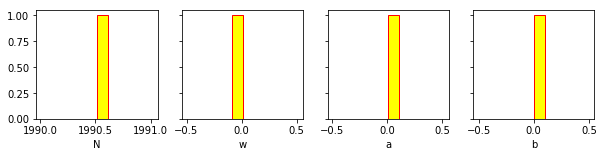

values for N and proportion
1990.516 1.0

values for w and proportion
0.009 1.0

values for a and proportion
0.01 1.0

values for b and proportion
0.001 1.0

values for (N,a,b) and proportion
(1990.516, 0.01, 0.001) 1.0


In [14]:
# plot the results
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 4, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].hist(values, label=key, facecolor='yellow', edgecolor='red')
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("values for {} and proportion".format(key))
    val = [round(v,3) for v in val]
    for v in set(val):
        print(v, val.count(v)/len(val))
    print()
    
print("values for (N,a,b) and proportion")
val = list()
for i in range(len(results['N'])):
    val.append((round(results['N'][i],3), round(results['a'][i],3), round(results['b'][i],3)))
for v in set(val):
    print(v, val.count(v)/len(val))

Set N,a,b to the most observed values and compute Q accordingly.

N, a, b =  1990.516 0.01 0.001


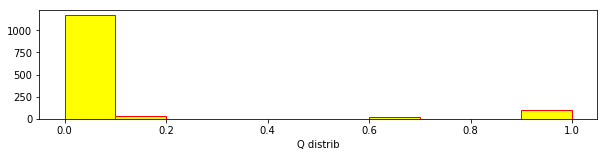

In [15]:
N, a, b = max([(v, val.count(v)/len(val)) for v in set(val)], key=itemgetter(1))[0]

# compute Q
for i in Q:
    for j in Q[i]:
        Q[i][j] = computeQij(w, a, b, N, E[i][j])
        
# plot
print("N, a, b = ", N,a,b)
plt.hist(flatten(Q), facecolor='yellow', edgecolor='red')
plt.xlabel("Q distrib")
plt.show()
plt.close()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

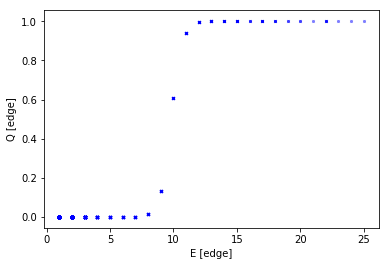

In [16]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = flatten(E)
y2plot = flatten(Q)
plt.scatter(x2plot, y2plot, color='blue', marker='x', alpha=.5, s=5)
plt.xlabel("E [edge]")
plt.ylabel("Q [edge]")
plt.show()

Get real graph.

In [17]:
G = nx.DiGraph()
G.add_nodes_from(users)

for line in open("../Datasets/leadgraph_test.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G.add_edge(leader, user)

### 3.2 Sample generation

We generate several sample graphs according to the posterior distribution. We compare their edges with edges from the real graph.

In [18]:
n_samples = 1000
prop_sampleEdges_in_real = list()
prop_realEdges_in_sample = list()

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for (i,j) in node_pairs:
        if i in Q:
            if j in Q[i] and random.random() < Q[i][j]:
                G_sample.add_edge(j,i)
            
    # compare edges in sample with real graph
    prop_sampleEdges_in_real = len([e for e in G_sample.edges if e in G.edges]) / G_sample.number_of_edges()
    prop_realEdges_in_sample = len([e for e in G.edges if e in G_sample.edges]) / G.number_of_edges()
    
# print results
print("Mean prop of sample edges present in real graph : ", np.mean(prop_sampleEdges_in_real))
print("Mean prop of real edges present in sample graph : ", np.mean(prop_realEdges_in_sample))

Mean prop of sample edges present in real graph :  0.9745762711864406
Mean prop of real edges present in sample graph :  0.41818181818181815


Compare expected degrees.

In [ ]:
expected_deg = 2*sum(flatten(Q))/n
var = 4*sum([q*(1-q) for q in flatten(Q)]) / n**2
std = np.sqrt(var)
print("Expected degree observed : {:.3f} with variance {:.3f} and std_dev {:.3f}".format(expected_deg, var, std))
print("Expected degree estimated from real graph : {:.3f}".format(np.mean(G.degree())))

## 4. Compare real graph, oursin, cascade and Newman

Get oursin graph.

In [30]:
G_oursin = util.nxgraph_from_trace(trace_path, False, Author)
G_cascade = util.nxgraph_from_trace(trace_path, True, Author)

Compare with Newman graph.

In [31]:
print("Mean nb edges in Newman graph : ", 0.5*expected_deg*n)
print("Nb edges in oursin graph : ", G_oursin.number_of_edges())
print("Nb edges in cascade graph : ", G_cascade.number_of_edges())
print("Real nb edges : ", G.number_of_edges())

NameError: name 'expected_deg' is not defined

Compare proportion of common edges.

In [27]:
n_samples = 1000
sample_in_real = list()
real_in_sample = list()
sample_in_oursin = list()
oursin_in_sample = list()
sample_in_cascade = list()
cascade_in_sample = list()

# edges lists
oursin_edges = set(G_oursin.edges)
cascade_edges = set(G_cascade.edges)
real_edges = set(G.edges)

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for e in node_pairs:
        if random.random() < Q[e]:
            G_sample.add_edge(e[1], e[0])
    sample_edges = set(G_sample.edges)
            
    # compare edges in sample with real graph
    nb_common_edges = len(sample_edges.intersection(real_edges))
    sample_in_real = nb_common_edges / len(sample_edges)
    real_in_sample = nb_common_edges / len(real_edges)
    
    # compare edges in sample with oursin graph
    nb_common_edges = len(sample_edges.intersection(oursin_edges))
    sample_in_oursin = nb_common_edges / len(sample_edges)
    oursin_in_sample = nb_common_edges / len(oursin_edges)
    
    # compare edges in sample with cascade graph
    nb_common_edges = len(sample_edges.intersection(cascade_edges))
    sample_in_cascade = nb_common_edges / len(sample_edges)
    cascade_in_sample = nb_common_edges / len(cascade_edges)
    
# compare oursin and cascade with real
oursin_in_real = len(oursin_edges.intersection(real_edges)) / len(oursin_edges)
real_in_oursin = len(oursin_edges.intersection(real_edges)) / len(real_edges)
cascade_in_real = len(cascade_edges.intersection(real_edges)) / len(cascade_edges)
real_in_cascade = len(cascade_edges.intersection(real_edges)) / len(real_edges)
oursin_in_cascade = len(oursin_edges.intersection(cascade_edges)) / len(oursin_edges)
cascade_in_oursin = len(oursin_edges.intersection(cascade_edges)) / len(cascade_edges)

# print results
print("Mean prop of sample edges that are in real graph : ", np.mean(sample_in_real))
print("Mean prop of real edges that are in sample graph : ", np.mean(real_in_sample))
print()
print("Mean prop of sample edges that are in oursin graph : ", np.mean(sample_in_oursin))
print("Mean prop of oursin edges that are in sample graph : ", np.mean(oursin_in_sample))
print()
print("Mean prop of sample edges that are in cascade graph : ", np.mean(sample_in_cascade))
print("Mean prop of cascade edges that are in sample graph : ", np.mean(cascade_in_sample))
print()
print("Prop of oursin edges that are in real graph : ", oursin_in_real)
print("Prop of real edges that are in oursin graph : ", real_in_oursin)
print()
print("Prop of cascade edges that are in real graph : ", cascade_in_real)
print("Prop of real edges that are in cascade graph : ", real_in_cascade)
print()
print("Prop of oursin edges that are in cascade graph : ", oursin_in_cascade)
print("Prop of cascade edges that are in oursin graph : ", cascade_in_oursin)

Mean prop of sample edges that are in real graph :  0.7492625368731564
Mean prop of real edges that are in sample graph :  0.9236363636363636

Mean prop of sample edges that are in oursin graph :  1.0
Mean prop of oursin edges that are in sample graph :  0.25223214285714285

Mean prop of sample edges that are in cascade graph :  0.8672566371681416
Mean prop of cascade edges that are in sample graph :  0.2419753086419753

Prop of oursin edges that are in real graph :  0.20461309523809523
Prop of real edges that are in oursin graph :  1.0

Prop of cascade edges that are in real graph :  0.22633744855967078
Prop of real edges that are in cascade graph :  1.0

Prop of oursin edges that are in cascade graph :  0.5424107142857143
Prop of cascade edges that are in oursin graph :  0.6
